<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE1] - Variational AutoEncoder (VAE) with MNIST
<!-- DESC --> Episode 1 : Model construction and Training

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example.  
François Chollet is not only the author of Keras and a great guru, he is also a sorcerer ;-)  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from modules.callbacks      import ImagesCallback
from modules.data_generator import DataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from IPython.display import display,Image,Markdown,HTML

from modules.VAE          import VAE, Sampling
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk


run_dir = './run/MNIST.001'
datasets_dir = pwk.init('VAE1', run_dir)

**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : VAE1
Run time             : Monday 21 December 2020, 22:14:18
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/MNIST.001
Running mode         : full
Update keras cache   : False
Save figs            : True
Path figs            : ./run/MNIST.001/figs


## Step 2 - Prepare data

In [2]:
x_train, _ = Loader_MNIST.get()

Dataset loaded.
Normalized.
Reshaped to (60000, 28, 28, 1)
Concatenate.


## Step 3 - Build model

In [3]:
latent_dim = 2

## Step 4 - Instanciate and compile model

#### Encoder

In [4]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

#### Decoder

In [5]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
# decoder.summary()

#### VAE

In [6]:
vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam())

## Step 5 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [7]:
# ---- Callback : Images
pwk.mkdir(f'{run_dir}/images')
filename = run_dir + "/images/image-{epoch:03d}-{i:02d}.jpg"
callbacks_images = ImagesCallback(filename, z_dim=latent_dim, decoder=decoder)

# ---- Callback : Best model
pwk.mkdir(f'{run_dir}/models')
filename = run_dir + "/models/best_model"
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = run_dir + "/logs"
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

callbacks_list = [callbacks_images, callback_bestmodel, callback_tensorboard]

In [8]:
%%time

history = vae.fit(x_train, epochs=30, batch_size=128, callbacks = callbacks_list,)

Epoch 1/30
547/547 [==============================] - 3s 5ms/step - loss: 208.2540 - reconstruction_loss: 205.4596 - kl_loss: 2.7944       (saved)
Epoch 2/30
547/547 [==============================] - 2s 4ms/step - loss: 180.3636 - reconstruction_loss: 177.3910 - kl_loss: 2.9726       (saved)
Epoch 3/30
547/547 [==============================] - 2s 4ms/step - loss: 163.3172 - reconstruction_loss: 159.6376 - kl_loss: 3.6795       (saved)
Epoch 4/30
547/547 [==============================] - 2s 4ms/step - loss: 157.7587 - reconstruction_loss: 154.0096 - kl_loss: 3.7491       (saved)
Epoch 5/30
547/547 [==============================] - 2s 4ms/step - loss: 154.8335 - reconstruction_loss: 151.0522 - kl_loss: 3.7814
Epoch 6/30
547/547 [==============================] - 2s 4ms/step - loss: 152.6908 - reconstruction_loss: 148.9141 - kl_loss: 3.7767
Epoch 7/30
547/547 [==============================] - 2s 4ms/step - loss: 151.1126 - reconstruction_loss: 147.3555 - kl_loss: 3.7571       (saved)

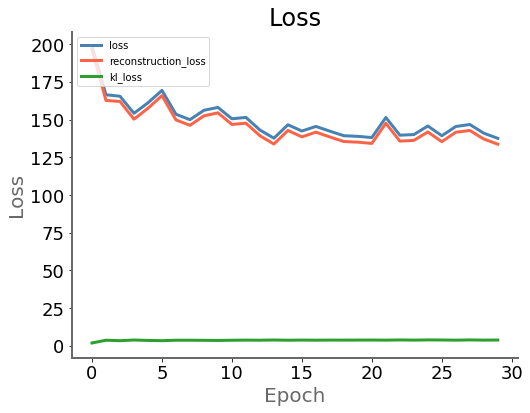

In [9]:
pwk.plot_history(history,  plot={"Loss":['loss','reconstruction_loss', 'kl_loss']}, save_as='history')

In [10]:
pwk.end()

End time is : Monday 21 December 2020, 21:59:00
Duration is : 00:02:24 1000ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>